# Computer Vision: CNN for Digit Recognition

In [1]:
import torch
import torch.nn as nn
import torch.cuda as cuda
import matplotlib.pyplot as plt

from torch.autograd import Variable

from torchvision import datasets
from torchvision import transforms

import torch.nn.functional as F

## Create DataLoaders

In [2]:
#mean and std dev of all pixels in MNIST dataset
mean_gray = 0.1307
stddev_gray = 0.3081

transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((mean_gray,), (stddev_gray,))])

mnist_train = datasets.MNIST('./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST('./data', train=False, download=True, transform=transform)

In [3]:
img = mnist_train[12][0].numpy() * stddev_gray + mean_gray

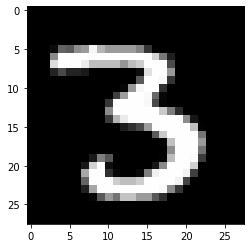

In [4]:
plt.imshow(img.reshape(28,28), cmap='gray');

In [5]:
label = mnist_train[12][1]
label

3

In [6]:
batch_size=1024

In [7]:
mnist_train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=1)
mnist_test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=True, num_workers=1)

## Create Model

In [8]:
class MNISTNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        #Convolution Layer 1
        #input = 28 x 28 x 1
        #output = 24 x 24 x 20
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5)
        self.relu1 = nn.ReLU()
        
        #Convolution Layer 2
        #input = 24 x 24 x 20
        #output = 20 x 20 x 30
        self.conv2 = nn.Conv2d(20,30,kernel_size=5)
        self.conv2_drop = nn.Dropout2d(p=0.5)
        
        #Pooling
        #output = 10 x 10 x 30
        self.maxpool2 = nn.MaxPool2d(2)
        self.relu2 = nn.ReLU()
        
        #Connected Layers
        self.fc1 = nn.Linear(3000,500)
        self.fc2 = nn.Linear(500,10)
        
    def forward(self, x):
        
        #Convolution Layer 1
        x = self.conv1(x)
        x = self.relu1(x)
        
        #Convolution Layer 2
        x = self.conv2(x)
        x = self.conv2_drop(x)
        x = self.maxpool2(x)
        x = self.relu2(x)
        
        #Switch from activation maps to vectors
        x = x.view(-1, 3000)
        
        #Fully Connected Layer 1
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, training=True)
        
        #Fully Connected Layer 2
        x = self.fc2(x)
        
        return x
        
        

## Create Objects

In [9]:
#Model
net = MNISTNet()

if cuda.is_available():
    net = net.cuda()

#Loss Function
criterion = nn.CrossEntropyLoss()

if cuda.is_available():
    criterion = criterion.cuda()

#Optimizer
learning_rate=0.01
optimizer = torch.optim.SGD(net.parameters(), lr = learning_rate, momentum = 0.9)

## Training

In [10]:
num_epochs = 100

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

for epoch in range(num_epochs):
    
    #Training
    
    iter_loss = 0.0
    correct = 0
    iterations = 0
    
    #Put network in training mode
    net.train()
    
    for i, (items, classes) in enumerate(mnist_train_loader):
        
        #Convert torch tensor to Variable
        items = Variable(items)
        classes = Variable(classes)
        
        #If we have GPU, shift data to GPU
        if cuda.is_available():
            items = items.cuda()
            classes = classes.cuda()
        
        
        #clear off gradients from past operations
        optimizer.zero_grad()
        
        #Do forward pass
        outputs=net(items)
        
        #Calculate loss
        loss = criterion(outputs, classes)
        
        #Accumulate Loss
        iter_loss += loss.item()
        
        #back propagation to calculate gradients
        loss.backward()
        
        #adjust optimizer
        optimizer.step()
        
        #Record correct predictions
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        iterations += 1
    
    #Record Training Loss
    train_loss.append(iter_loss/iterations)
    
    #Record Training Accuracy
    train_accuracy.append((100.0 * correct / len(mnist_train_loader.dataset)))
    
    #Validation
    
    loss = 0.0
    correct = 0
    iterations = 0
    
    #Put network in eval mode
    net.eval()
    
    for i, (items, classes) in enumerate(mnist_test_loader):
        
        #Convert torch tensor to Variable
        items = Variable(items)
        classes = Variable(classes)
        
        #If we have GPU, shift data to GPU
        if cuda.is_available():
            items = items.cuda()
            classes = classes.cuda()
        
        #Forward Pass
        outputs = net(items)
        
        #Calculate Loss
        loss += criterion(outputs, classes).item()
        
        #Record Correct Predictions for Training Data
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        
        iterations += 1
    
    #Record Test Loss
    test_loss.append(loss / iterations)
    
    #Record Test Accuracy
    test_accuracy.append((100.0 * correct / len(mnist_test_loader.dataset)))
    
    print('Epoch %d/%d, Training Loss: %.4f, Training Accuracy: %.4f, Test Loss: %.4f, Test Accuracy: %.4f'
         % (epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], test_loss[-1], test_accuracy[-1]))
    

Epoch 1/100, Training Loss: 1.2249, Training Accuracy: 60.7900, Test Loss: 0.3489, Test Accuracy: 89.6400
Epoch 2/100, Training Loss: 0.3349, Training Accuracy: 90.1767, Test Loss: 0.2019, Test Accuracy: 93.9600
Epoch 3/100, Training Loss: 0.2310, Training Accuracy: 93.1917, Test Loss: 0.1493, Test Accuracy: 95.4400
Epoch 4/100, Training Loss: 0.1796, Training Accuracy: 94.7450, Test Loss: 0.1167, Test Accuracy: 96.3600
Epoch 5/100, Training Loss: 0.1502, Training Accuracy: 95.5783, Test Loss: 0.0953, Test Accuracy: 97.1300
Epoch 6/100, Training Loss: 0.1310, Training Accuracy: 96.1300, Test Loss: 0.0869, Test Accuracy: 97.3200
Epoch 7/100, Training Loss: 0.1171, Training Accuracy: 96.5083, Test Loss: 0.0765, Test Accuracy: 97.5400
Epoch 8/100, Training Loss: 0.1061, Training Accuracy: 96.8183, Test Loss: 0.0711, Test Accuracy: 97.8200
Epoch 9/100, Training Loss: 0.0995, Training Accuracy: 97.0583, Test Loss: 0.0671, Test Accuracy: 97.8900
Epoch 10/100, Training Loss: 0.0921, Training 

Epoch 77/100, Training Loss: 0.0212, Training Accuracy: 99.2950, Test Loss: 0.0323, Test Accuracy: 99.0100
Epoch 78/100, Training Loss: 0.0196, Training Accuracy: 99.3583, Test Loss: 0.0323, Test Accuracy: 99.0700
Epoch 79/100, Training Loss: 0.0187, Training Accuracy: 99.4000, Test Loss: 0.0322, Test Accuracy: 99.1300
Epoch 80/100, Training Loss: 0.0188, Training Accuracy: 99.3850, Test Loss: 0.0330, Test Accuracy: 99.0800
Epoch 81/100, Training Loss: 0.0192, Training Accuracy: 99.3833, Test Loss: 0.0295, Test Accuracy: 99.0900
Epoch 82/100, Training Loss: 0.0184, Training Accuracy: 99.4200, Test Loss: 0.0327, Test Accuracy: 99.0600
Epoch 83/100, Training Loss: 0.0188, Training Accuracy: 99.3733, Test Loss: 0.0333, Test Accuracy: 99.0400
Epoch 84/100, Training Loss: 0.0186, Training Accuracy: 99.4050, Test Loss: 0.0303, Test Accuracy: 99.0700
Epoch 85/100, Training Loss: 0.0194, Training Accuracy: 99.3833, Test Loss: 0.0305, Test Accuracy: 99.0600
Epoch 86/100, Training Loss: 0.0176, 

## Visualizing Loss and Accuracy

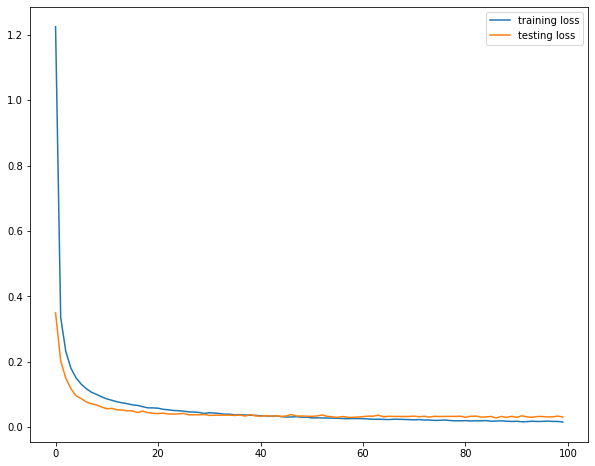

In [11]:
#Loss
f = plt.figure(figsize=(10,8))
plt.plot(train_loss, label = 'training loss')
plt.plot(test_loss, label = 'testing loss')
plt.legend()
plt.show()

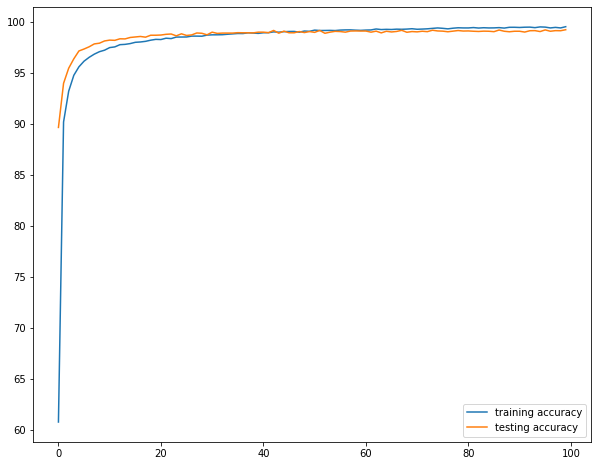

In [12]:
#Accuracy
f = plt.figure(figsize=(10,8))
plt.plot(train_accuracy, label = 'training accuracy')
plt.plot(test_accuracy, label = 'testing accuracy')
plt.legend()
plt.show()

In [13]:
#Standalone Inference
image_index = 23
img = mnist_test[image_index][0].resize_((1,1,28,28))
img = Variable(img)
label = mnist_test[image_index][1]

net.eval()

if cuda.is_available():
    net = net.cuda()
    img = img.cuda()
else:
    net = net.cpu()
    img = img.cpu()
    
output = net(img)
output.data

tensor([[ -5.4313, -14.1653,  -9.9394,   8.3940, -13.7600,  33.8039,  10.5854,
         -15.7593,   0.8024,   9.9187]], device='cuda:0')

In [19]:
_, predicted = torch.max(output.data, 1)
print('Prediction is: ', predicted)

Prediction is:  tensor([5], device='cuda:0')


In [15]:
print('Actual is: ', label)

Actual is:  5
